In [1255]:
import warnings
warnings.filterwarnings('ignore')

import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns

import itertools
from itertools import cycle

from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc

from datetime import date, datetime, timedelta


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from torch import nn, optim
import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [1256]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

(123, 1) (129, 1) (276, 1)


,RHR,steps,sleep
2024-07-13,61.479138,19.415799,387.140625
2024-07-14,61.903125,13.138092,391.942500
2024-07-15,62.250794,15.096049,387.324153
2024-07-16,61.846516,9.293038,373.415789
2024-07-17,61.483994,14.234533,380.598837
...,...,...,...
2024-11-08,62.896629,3.925384,376.280000
2024-11-09,62.818185,3.472641,375.600000
2024-11-10,62.025778,11.108802,357.129255
2024-11-11,61.688097,7.257422,349.798707


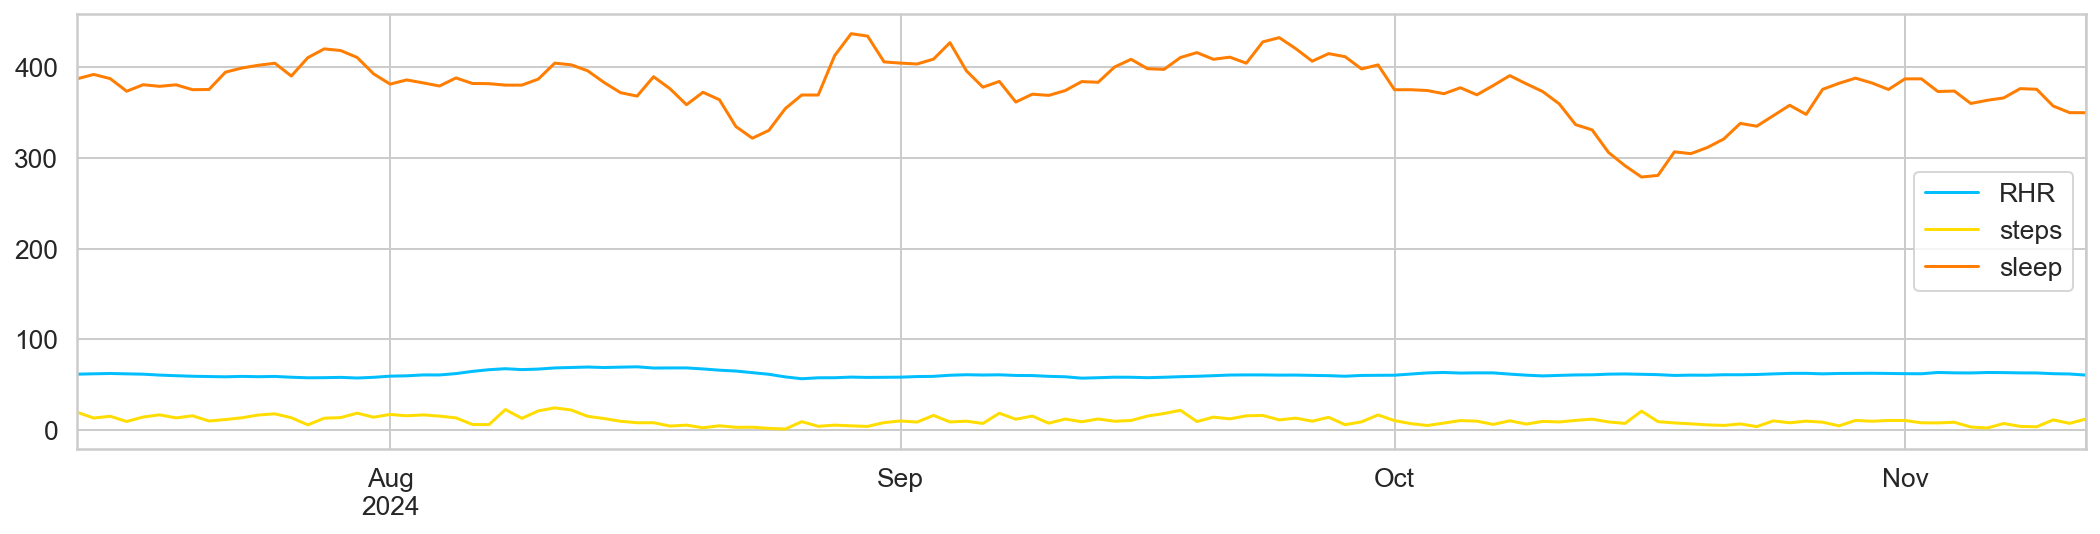

In [1257]:
# symptom:  2024-08-14


# read files 
df_hr = pd.read_csv("COVID-19-Wearables/ASFODQR_hr.csv")
df_steps = pd.read_csv("COVID-19-Wearables/ASFODQR_steps.csv")
df_sleep = pd.read_csv("COVID-19-Wearables/ASFODQR_sleep.csv")


# resting heart rate --------------------------------------------

df_hr = df_hr.set_index('datetime')
df_hr.index.name = None
df_hr.index = pd.to_datetime(df_hr.index)

# steps data
df1_steps = df_steps.set_index('datetime')
df1_steps.index.name = None
df1_steps.index = pd.to_datetime(df1_steps.index)

# merge dataframes
#df_hr = df_hr.resample('1min').median()
#df_steps = df_steps.resample('1min').median()

df1_rhr = pd.merge(df_hr, df1_steps, left_index=True, right_index=True)
df1_rhr = df1_rhr.resample('1min').mean()
df1_rhr = df1_rhr.dropna()
#df1_rhr = df1_rhr.between_time('23:00','6:00')

# define RHR as the HR measurements recorded when there were zero steps taken during a rolling time window of the preceding 12 minutes (including the current minute)
df1_rhr['steps_window_12'] = df1_rhr['steps'].rolling(12).sum()
df1_rhr = df1_rhr.loc[(df1_rhr['steps_window_12'] == 0)]

# This function takes resting heart rate data and applies moving averages to smooth the data and downsamples to one hour by taking the avegare values
df1_rhr = df1_rhr.dropna()
df1_rhr = df1_rhr.rolling(400).mean()

# resample
df1_rhr = df1_rhr.resample('24H').mean()
df1_rhr = df1_rhr.drop(['steps'], axis=1)
df1_rhr = df1_rhr.drop(['steps_window_12'], axis=1)
df1_rhr = df1_rhr.dropna()
df1_rhr = df1_rhr.rename(columns={"heartrate": "RHR"})

#print(df1_rhr.head())

# steps --------------------------------------------
df2_steps = df_steps[['datetime', 'steps']]
df2_steps = df2_steps.set_index('datetime')
df2_steps.index.name = None
df2_steps.index = pd.to_datetime(df1_steps.index)
#df2_steps = df2_steps.between_time('23:00','6:00')
df2_steps = df2_steps.rolling(400).mean()
df2_steps = df2_steps.resample('24H').mean()

#print(df2_steps.head())

# sleep --------------------------------------------
df1_sleep = df_sleep[['datetime', 'stage_duration']]
df1_sleep = df1_sleep.set_index('datetime')
df1_sleep.index.name = None
df1_sleep.index = pd.to_datetime(df1_sleep.index)
df1_sleep = df1_sleep.rename(columns={"stage_duration": "sleep"})
#df1_sleep = df1_sleep.between_time('23:00','6:00')
df1_sleep = df1_sleep.rolling(400).mean()
df1_sleep = df1_sleep.resample('24H').mean()
print(df1_rhr.shape, df2_steps.shape, df1_sleep.shape)

df2 = df1_rhr.merge(df2_steps, left_index=True, right_index=True).merge(df1_sleep,left_index=True, right_index=True)

df2 = df2.ffill()

df2.plot(figsize=(18,4))
df2

## Data splitting and standardizing

In [1258]:
train = df2[:20]
test = df2[20:]

# split train into train and validation datasets
# random sampling to avoid order
# split train into valid by random sampling and by not reproducing the same values

df4 = train.sample(frac=0.1, replace=False, random_state=1)
df5 = pd.merge(train, df4, how='outer', left_index=True, right_index=True, indicator=True)

df5_train = df5.query('_merge != "both"')
df5_train = df5_train.drop(['RHR_y', 'steps_y', 'sleep_y','_merge'], axis=1)
df5_train = df5_train.rename(columns={"RHR_x": "RHR", "steps_x":"steps", "sleep_x":"sleep"})

# valid
df5_valid = df5.query('_merge == "both"')
df5_valid = df5_valid.drop(['RHR_y', 'steps_y', 'sleep_y','_merge'], axis=1)
df5_valid = df5_valid.rename(columns={"RHR_x": "RHR", "steps_x":"steps", "sleep_x":"sleep"})

print(df5_train.shape, df5_valid.shape)


# standardize
scaler = StandardScaler().fit(train[['RHR']])
train[['RHR']] = scaler.fit_transform(train[['RHR']])
test[['RHR']] = scaler.transform(test[['RHR']])
df5_train[['RHR']] = scaler.transform(df5_train[['RHR']])
df5_valid[['RHR']] = scaler.transform(df5_valid[['RHR']])

scaler = StandardScaler().fit(train[['steps']])
train[['steps']] = scaler.fit_transform(train[['steps']])
test[['steps']] = scaler.transform(test[['steps']])
df5_train[['steps']] = scaler.transform(df5_train[['steps']])
df5_valid[['steps']] = scaler.transform(df5_valid[['steps']])

scaler = StandardScaler().fit(train[['sleep']])
train[['sleep']] = scaler.fit_transform(train[['sleep']])
test[['sleep']] = scaler.transform(test[['sleep']])
df5_train[['sleep']] = scaler.transform(df5_train[['sleep']])
df5_valid[['sleep']] = scaler.transform(df5_valid[['sleep']])



# split test into test_normal and test_anomaly datasets
symptom_date = '2024-08-14'
symptom_date = pd.to_datetime(symptom_date)
symptom_date_before_7 = pd.to_datetime(symptom_date) + timedelta(days=-7)
symptom_date_after_21 = pd.to_datetime(symptom_date) + timedelta(days=21)
                  
test_anomaly = test[symptom_date_before_7:symptom_date_after_21]
test_normal = pd.merge(test,test_anomaly,  how='outer',  left_index=True, right_index=True)

test_normal = test_normal.loc[test_normal['RHR_y'].isnull()]
test_normal = test_normal.drop('RHR_y', axis=1)
test_normal = test_normal.rename({'RHR_x':'RHR'}, axis=1)

test_normal = test_normal.loc[test_normal['steps_y'].isnull()]
test_normal = test_normal.drop('steps_y', axis=1)
test_normal = test_normal.rename({'steps_x':'steps'}, axis=1)

test_normal = test_normal.loc[test_normal['sleep_y'].isnull()]
test_normal = test_normal.drop('sleep_y', axis=1)
test_normal = test_normal.rename({'sleep_x':'sleep'}, axis=1)

print(train.shape, test.shape, test_normal.shape, test_anomaly.shape)

(18, 3) (2, 3)
(20, 3) (103, 3) (74, 3) (29, 3)


## Creating LSTM input

In [1259]:
# convert data with one feature innto tensor

def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [1260]:
train_dataset, seq_len, n_features = create_dataset(df5_train)
val_dataset, _, _ = create_dataset(df5_valid)
test_dataset, _, _ = create_dataset(test)
test_normal_dataset, _, _ = create_dataset(test_normal)
test_anomaly_dataset, _, _ = create_dataset(test_anomaly)
# train_dataset.Size()

## Model

In [1261]:

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [1262]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [1263]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [1264]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=128)
model = model.to(device)

## Training

In [1265]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # default 0.01 LR
  criterion = nn.L1Loss(reduction='sum').to(device) # MAE = L1 Loss
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad() # using zero gradient.

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true) # measure error for the prediction

      loss.backward() # backpropagation
      optimizer.step() # optimizationn

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [1266]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=120
)

Epoch 1: train loss 2.3459281391567655 val loss 3.5673341751098633
Epoch 2: train loss 2.30524809161822 val loss 3.5928597450256348
Epoch 3: train loss 2.3014849755499096 val loss 3.5854735374450684
Epoch 4: train loss 2.2956837117671967 val loss 3.5711982250213623
Epoch 5: train loss 2.2498507830831738 val loss 3.4967793226242065
Epoch 6: train loss 2.208819932407803 val loss 3.7005255222320557
Epoch 7: train loss 2.125324865182241 val loss 3.0163469314575195
Epoch 8: train loss 2.0651072561740875 val loss 2.991361975669861
Epoch 9: train loss 2.0632981889777713 val loss 2.664573609828949
Epoch 10: train loss 1.969519750939475 val loss 3.040261745452881
Epoch 11: train loss 2.121410402986738 val loss 2.4431761503219604
Epoch 12: train loss 2.0444977614614697 val loss 3.049377679824829
Epoch 13: train loss 2.145198014047411 val loss 2.838241219520569
Epoch 14: train loss 1.926620579428143 val loss 2.3992812633514404
Epoch 15: train loss 1.4753288163079157 val loss 1.7247829884290695
Ep

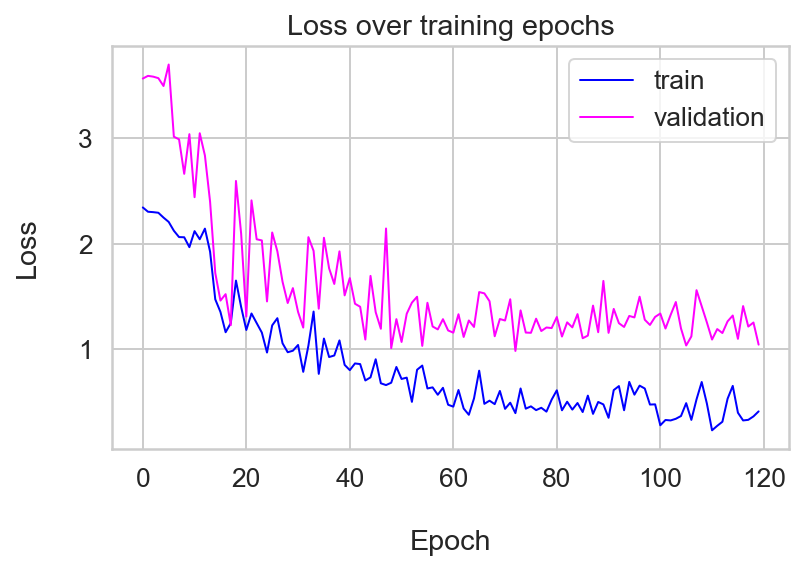

In [1292]:
# the loss seems to be equal and it is an indication that our model is not overfitting.

ax = plt.figure(figsize=(6,4)).gca()

ax.plot(history['train'], lw=1, c='blue')
ax.plot(history['val'], lw=1, c='magenta')
plt.ylabel('Loss\n')
plt.xlabel('\nEpoch')
plt.legend(['train', 'validation'])
plt.tight_layout()
plt.title('Loss over training epochs')
plt.show();

In [1268]:
## Save the model

MODEL_PATH = 'ASFODQR.pth'
torch.save(model, MODEL_PATH)

## Choosing threshold

In [1269]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

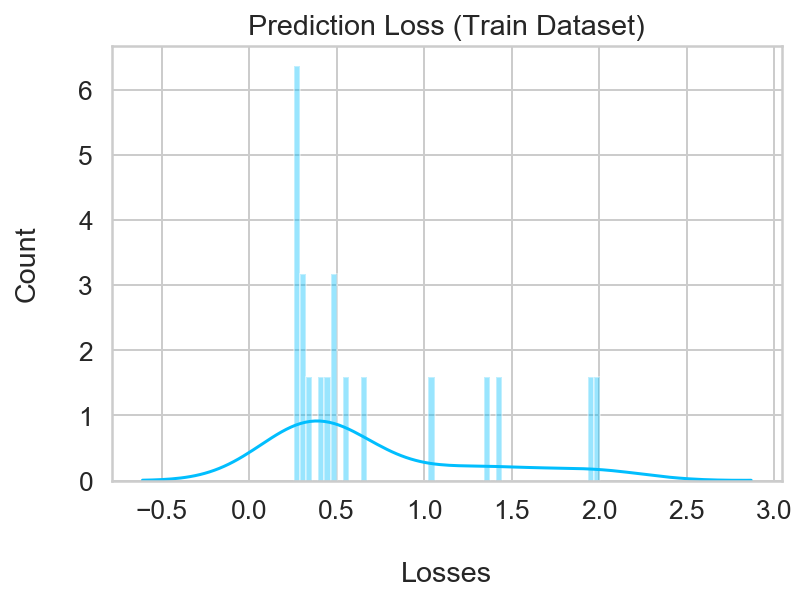

In [1304]:
_, losses = predict(model, train_dataset)
ax = plt.figure(figsize=(6,4)).gca()
ax = sns.distplot(losses, bins=50, kde=True).set_title('Prediction Loss (Train Dataset)')
plt.xlabel('\nLosses')
# Set y-axis label
plt.ylabel('Count\n')
plt.show()

In [1271]:
# Computing likelihood of anomaly

stats = pd.DataFrame(losses).describe()
print(stats)

mean = stats.filter(like='mean', axis=0)
mean = float(mean[0])


std = stats.filter(like='std', axis=0)
std = float(std[0])

THRESHOLD = mean + std + 1
THRESHOLD

               0
count  18.000000
mean    0.715565
std     0.582880
min     0.255725
25%     0.298178
50%     0.475600
75%     0.953010
max     2.003662


2.2984444069382635

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

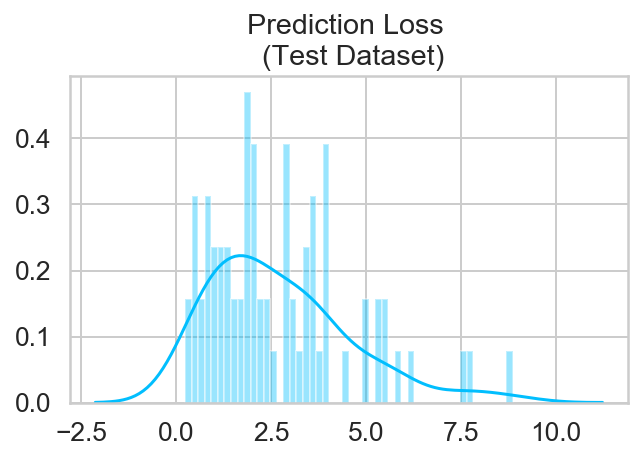

In [1272]:
# evaluation
# TEST Normal

predictions, pred_losses = predict(model, test_normal_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

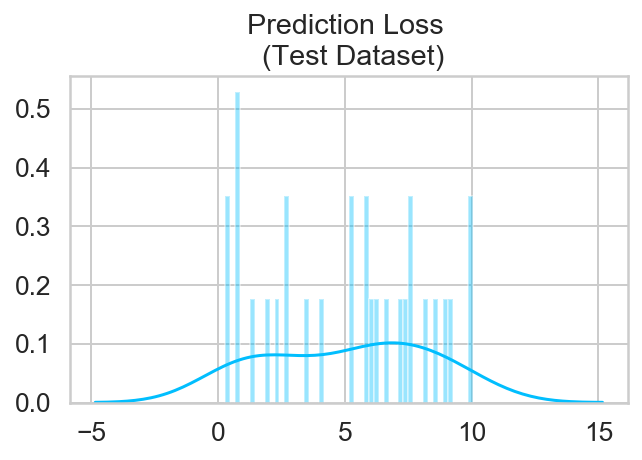

In [1273]:
# evaluation
# TEST Anomaly

predictions, pred_losses = predict(model, test_anomaly_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

Text(0.5, 1.0, 'Prediction Loss \n (Test Dataset)')

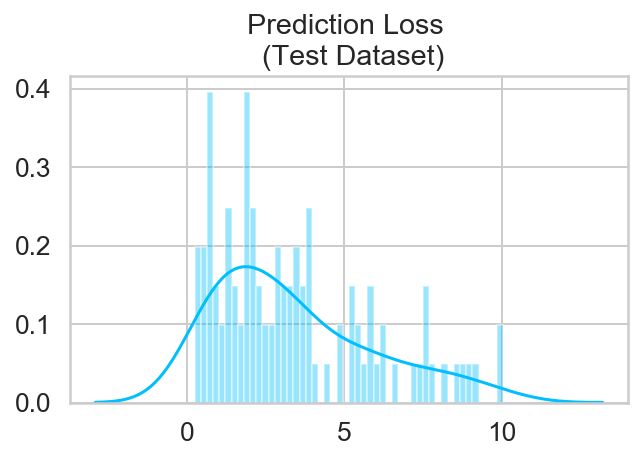

In [1274]:
# evaluation
# TEST 

predictions, pred_losses = predict(model, test_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Test Dataset)')

In [1275]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_normal_dataset)}')

Anomaly predictions: 45/74


In [1276]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_anomaly_dataset)}')

Anomaly predictions: 45/29


In [1277]:
anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(test_dataset)}')

Anomaly predictions: 45/103


## Save annomalies and visualize

In [1278]:

df3_test = test.reset_index()
df3_test = df3_test.rename(columns={'index':'datetime'})

test_score_df = df3_test
test_score_df['loss'] = pred_losses
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

# save all anomalies
test_score_df = test_score_df.set_index("datetime")
anomalies = test_score_df[test_score_df.anomaly == True]

# save anomalies in positive direction
# anomalies = anomalies[anomalies.RHR >=0]

anomalies.to_csv('ASFODQR_anomalies.csv')
anomalies


,RHR,steps,sleep,loss,threshold,anomaly
datetime,,,,,,
2024-08-06,3.292634,-2.472836,-0.758734,4.440435,2.298444,True
2024-08-07,4.464259,-2.527296,-0.773499,6.296499,2.298444,True
2024-08-08,5.171566,2.600847,-0.888425,5.279553,2.298444,True
2024-08-09,4.541206,-0.384694,-0.888425,5.778172,2.298444,True
2024-08-10,4.904745,2.153642,-0.417106,4.018165,2.298444,True
2024-08-11,5.719493,3.178400,0.832064,5.869872,2.298444,True
2024-08-12,6.022945,2.445080,0.699510,5.271812,2.298444,True
2024-08-13,6.347441,0.293422,0.232218,6.603962,2.298444,True
2024-08-14,6.003339,-0.467306,-0.687361,7.333086,2.298444,True


In [1279]:
# mereg all datasets

# pd.merge(train_data, valid_data, test_data)

all_merged = pd.concat([df5_train, df5_valid, test])


In [1280]:
all_merged

,RHR,steps,sleep
2024-07-13,1.312907,1.656962,-0.392498
2024-07-14,1.583814,-0.282369,-0.051845
2024-07-15,1.805957,0.322490,-0.379478
2024-07-17,1.316010,0.056347,-0.856583
2024-07-18,0.676968,0.803043,-0.982654
...,...,...,...
2024-11-08,2.218614,-3.128391,-1.162969
2024-11-09,2.168493,-3.268254,-1.211209
2024-11-10,1.662183,-0.909264,-2.521555
2024-11-11,1.446422,-2.099046,-3.041597


Anomaly predictions: 65/123


,RHR,steps,sleep,predictions,loss,threshold,anomaly
datetime,,,,,,,
2024-08-06,3.292634,-2.472836,-0.758734,1.859831,4.440435,2.298444,True
2024-08-07,4.464259,-2.527296,-0.773499,1.891368,6.296499,2.298444,True
2024-08-08,5.171566,2.600847,-0.888425,1.405673,5.279553,2.298444,True
2024-08-09,4.541206,-0.384694,-0.888425,1.737774,5.778172,2.298444,True
2024-08-10,4.904745,2.153642,-0.417106,1.487682,4.018165,2.298444,True
2024-08-11,5.719493,3.178400,0.832064,1.301420,5.869872,2.298444,True
2024-08-12,6.022945,2.445080,0.699510,1.475550,5.271812,2.298444,True
2024-08-13,6.347441,0.293422,0.232218,1.787137,6.603962,2.298444,True
2024-08-14,6.003339,-0.467306,-0.687361,1.787163,7.333086,2.298444,True


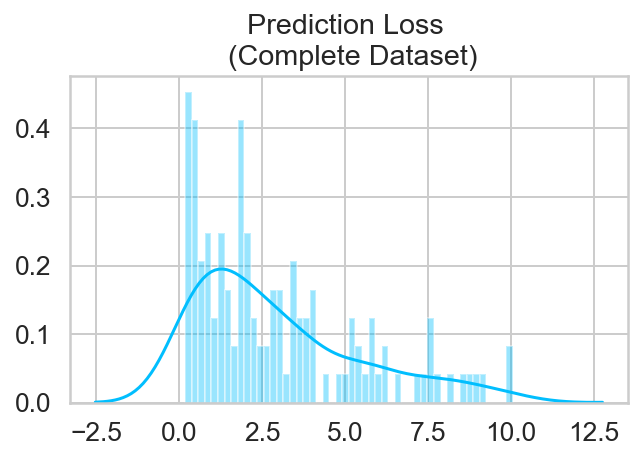

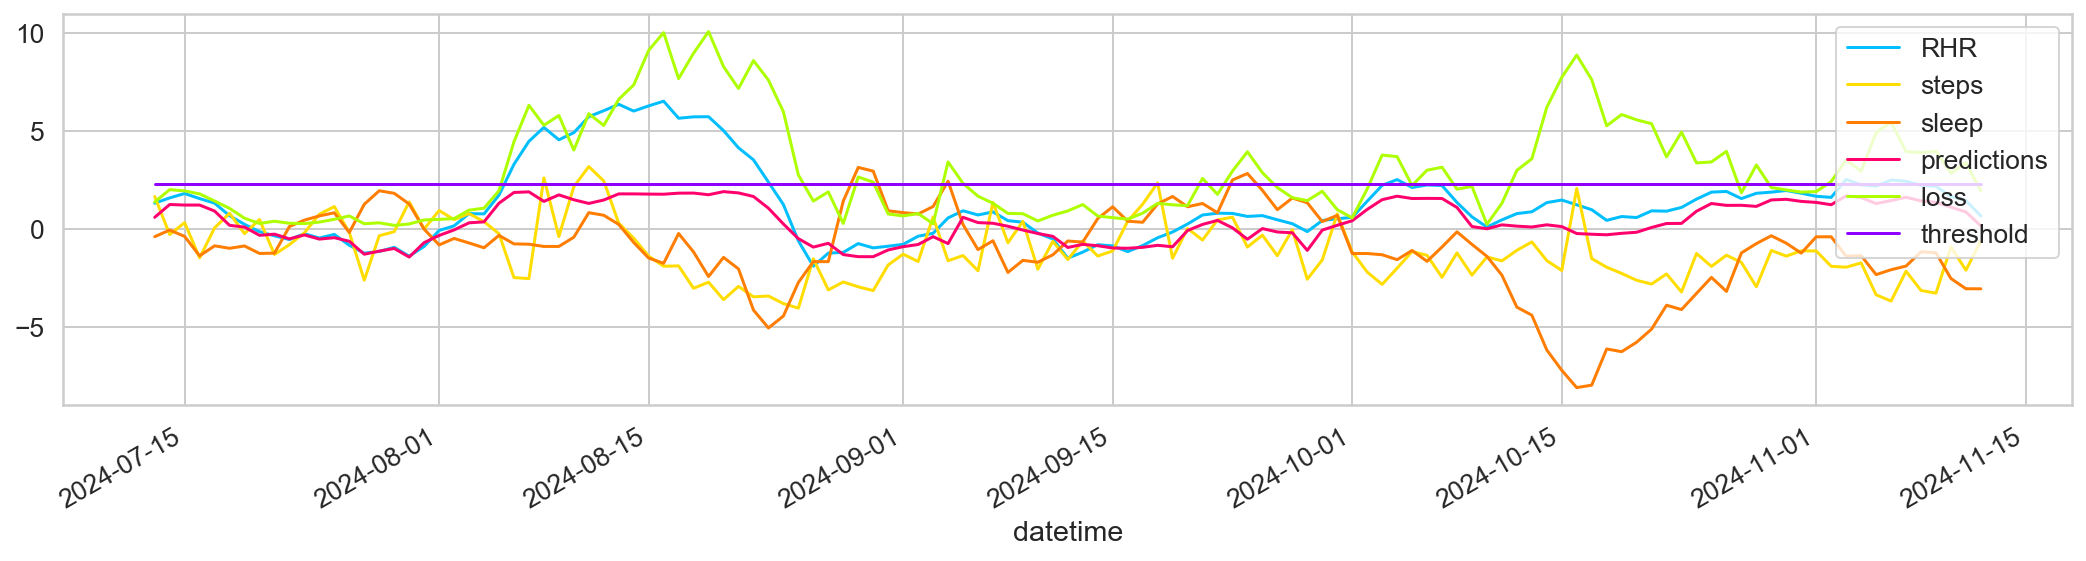

In [1281]:
## Evaluatinng using the complete dataset



all_dataset, _, _ = create_dataset(all_merged)

predictions, pred_losses = predict(model, all_dataset)
plt.figure(figsize=(5,3))
sns.distplot(pred_losses, bins=50, kde=True).set_title('Prediction Loss \n (Complete Dataset)')

anomalies = sum(l < THRESHOLD for l in pred_losses)
print(f'Anomaly predictions: {anomalies}/{len(all_dataset)}')

df3_all = all_merged.reset_index()
df3_all = df3_all.rename(columns={'index':'datetime'})

all_score_df = df3_all
all_score_df['predictions'] = predictions
all_score_df['loss'] = pred_losses
all_score_df['threshold'] = THRESHOLD
all_score_df['anomaly'] = all_score_df.loss > all_score_df.threshold
all_score_df['predictions'] = all_score_df['predictions'].str[0]
all_score_df = all_score_df.set_index("datetime")
all_score_df.plot(figsize=(18,4))

all_score_df[(all_score_df.anomaly == True) ]

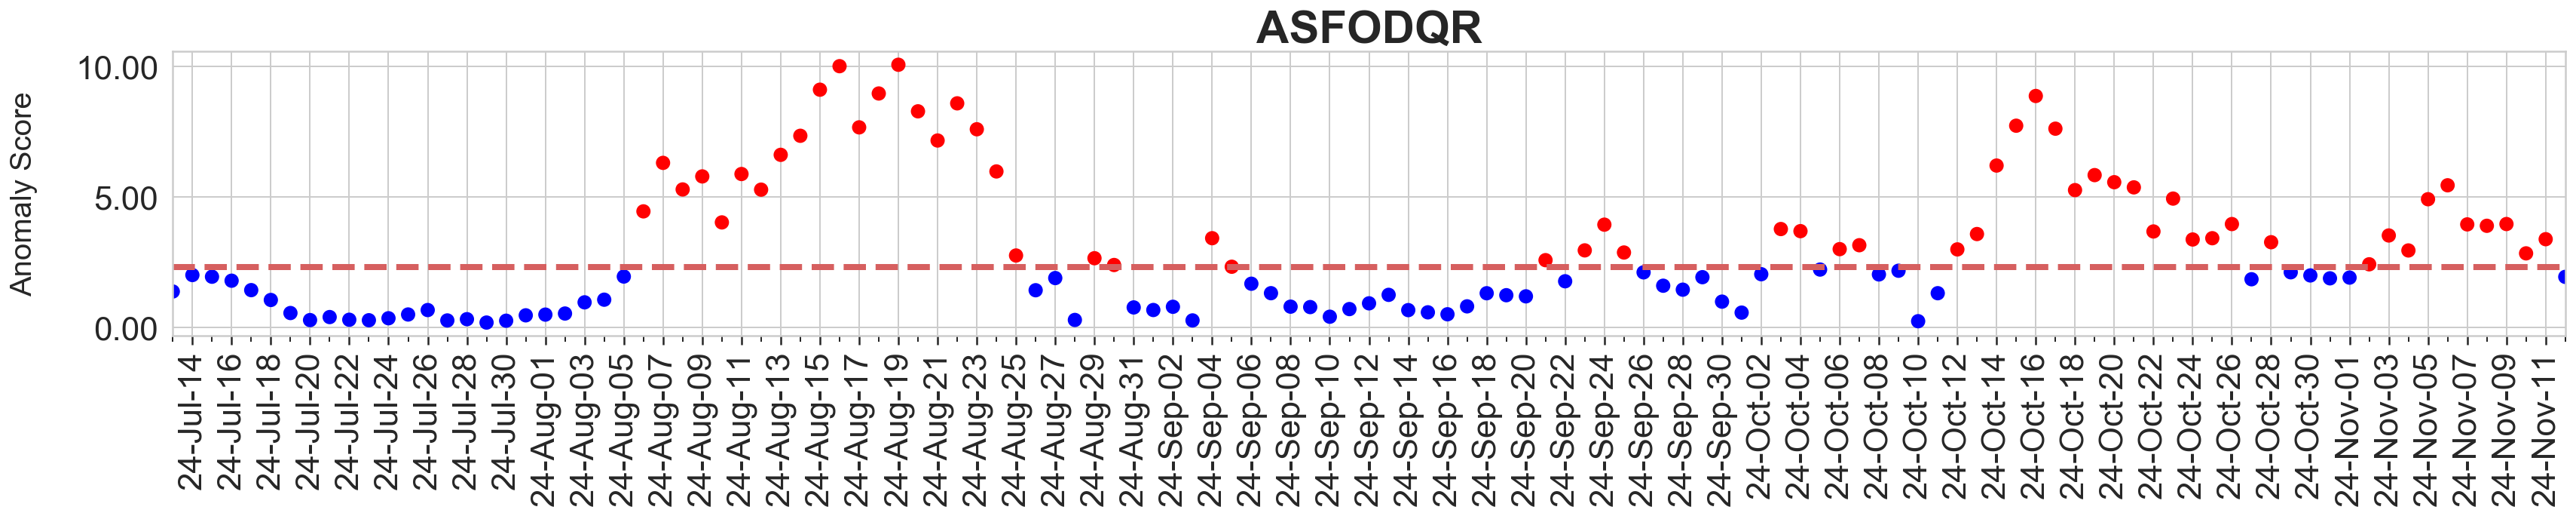

In [1282]:
# plot anomaly scores

all_score_df1 = all_score_df.reset_index()

ax3 = all_score_df1.plot.scatter(x='datetime',y='loss', figsize=(24,5),  rot=90,
                                marker='o', lw=5,
                                c=['red' if i== True else 'blue'  for i in all_score_df1['anomaly']])




ax3.set_xlim(all_score_df1['datetime'].iloc[0], all_score_df1['datetime'].iloc[-1]) 
ax3.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b-%d'))
ax3.set_ylabel('Anomaly Score\n', fontsize = 20) # Y label
ax3.set_xlabel('', fontsize = 0) # X label
ax3.tick_params(axis='both', which='major', labelsize=22)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.set_title('ASFODQR',fontweight="bold", size=30) # Title
plt.axhline(y=THRESHOLD, color='r', linestyle='--', lw=4)
plt.tick_params(axis='both',which='both',bottom=True, top=False, labelbottom=True) 
plt.tight_layout()

#plt.savefig('ASFODQR_all_anomaly_scores.pdf', bbox_inches='tight')  
plt.show()


## Metrics

In [1283]:
# True positives (TP) are the number of anomalous days that are correctly identified as anomalous,
# False negatives (FN) are the no.of anomalous days that are incorrectly identified as normal.


#7-21 window (True preds are TPs and False are TNs)
all_score_df1 = all_score_df[['anomaly', 'predictions']]
test_anomaly_df1 = all_score_df1[symptom_date_before_7:symptom_date_after_21]
test_anomaly_df1 = test_anomaly_df1.groupby(['anomaly']).count()
test_anomaly_df1 = test_anomaly_df1.reset_index()

test_anomaly_df2 = test_anomaly_df1[test_anomaly_df1['anomaly'] == True]
TP = int(test_anomaly_df2['predictions'].values) if len(test_anomaly_df2)>0 else 0
print("TP:", TP)

test_anomaly_df3 = test_anomaly_df1[test_anomaly_df1['anomaly'] == False]
FN = int(test_anomaly_df3['predictions'].values) if len(test_anomaly_df3)>0 else 0
print("FN:", FN)

# True negative (TN) are the number of normal days that are correctly identified as normal
# False positives (FP) are the no.of normal days that are incorrectly identified as anomalous. 

#7: window (False=1)
test_normal_df1 = pd.merge(test_normal, all_score_df,  how='outer',  left_index=True, right_index=True)

test_normal_df1 = test_normal_df1.loc[test_normal_df1['RHR_x'].notnull()]
test_normal_df1 = test_normal_df1.drop({'RHR_x', 'steps_x', 'sleep_x'},  axis=1)
test_normal_df1 = test_normal_df1.rename({'RHR_y':'RHR', 'steps_y':'steps', 'sleep_x': 'sleep'}, axis=1)

test_normal_df1 = test_normal_df1.groupby(['anomaly']).count()
test_normal_df1 = test_normal_df1.reset_index()

test_normal_df2 = test_normal_df1[test_normal_df1['anomaly'] == False]
TN = int(test_normal_df2['predictions'].values) if len(test_normal_df2)>0 else 0
print("TN:", TN)

test_normal_df3 = test_normal_df1[test_normal_df1['anomaly'] == True]
FP = int(test_normal_df3['predictions'].values) if len(test_normal_df3)>0 else 0

print("FP:", FP)

TP: 22
FN: 7
TN: 38
FP: 36


In [1284]:
def metrics(tp, fp, tn, fn):
    sensitivity = tp / (tp+fn),
    specificity = tn / (tn+fp),
    precision = tp / (tp+fp),
    recall = tn / (tn+fn),
    return sensitivity, specificity, precision, recall
    

metrics_tuple = metrics(TP, FP, TN, FN)

metrics_list = list(itertools.chain.from_iterable(metrics_tuple))
metrics_df = pd.DataFrame([metrics_list])
metrics_df.columns =['Sensitivity','Specificity','Precision', 'Recall']
metrics_df.rename({0: 'ASFODQR'}, axis='index')
metrics_df.index = ['ASFODQR']
metrics_df

,Sensitivity,Specificity,Precision,Recall
ASFODQR,0.758621,0.513514,0.37931,0.844444


In [1285]:
def metrics(tp, fp, tn, fn):
    sensitivity = tp / (tp+fn),
    specificity = tn / (tn+fp),
    precision = tp / (tp+fp),
    recall = tn / (tn+fn),
    return sensitivity, specificity, precision, recall
    

sensitivity, specificity, precision, recall= metrics(TP, FP, TN, FN)

metrics_list = (TP, FP, TN, FN, sensitivity, specificity, precision, recall)

metrics_df = pd.DataFrame([metrics_list])
metrics_df.columns =['TP', 'FP', 'TN', 'FN', 'Sensitivity','Specificity','Precision', 'Recall']
metrics_df.rename({0:  'ASFODQR'}, axis='index')
metrics_df.index = [ 'ASFODQR']
metrics_df

,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall
ASFODQR,22,36,38,7,"(0.7586206896551724,)","(0.5135135135135135,)","(0.3793103448275862,)","(0.8444444444444444,)"


## ROC

In [1286]:
def test_normal_types(anomaly):
    if anomaly['anomaly'] == True:
        return 1
    elif anomaly['anomaly'] == False:
        return 0
    else:
        return 'OTHER'


def test_anomaly_types(anomaly):
    if anomaly['anomaly'] == False:
        return 1
    elif anomaly['anomaly'] == True:
        return 0
    else:
        return 'OTHER'
  
all_score_df1 = all_score_df[['anomaly', 'predictions']]
test_anomaly_df1 = all_score_df1[symptom_date_before_7:symptom_date_after_21]

test_normal_df1 = pd.merge(test_normal, all_score_df,  how='outer',  left_index=True, right_index=True)
test_normal_df1 = test_normal_df1.loc[test_normal_df1['RHR_x'].notnull()]
test_normal_df1 = test_normal_df1.drop({'RHR_x'},  axis=1)
test_normal_df1 = test_normal_df1.rename({'RHR_y':'RHR'}, axis=1)


test_anomaly_df1['y_score'] = test_anomaly_df1.apply(test_anomaly_types, axis=1)
test_anomaly_df1['y_test'] = '1'

test_normal_df1['y_score'] = test_normal_df1.apply(test_normal_types, axis=1)
test_normal_df1['y_test'] = '0'

preds = pd.concat([test_anomaly_df1, test_normal_df1], axis=0)
preds1 = preds.drop(['anomaly', 'predictions', 'loss', 'threshold', 'RHR'], axis=1)
preds2 = preds1.reset_index()
preds2 = preds2.rename({'index':'datetime'}, axis=1)
preds2 = preds2[['datetime', 'y_score', 'y_test']]

preds2

,datetime,y_score,y_test
0,2024-08-07,0,1
1,2024-08-08,0,1
2,2024-08-09,0,1
3,2024-08-10,0,1
4,2024-08-11,0,1
...,...,...,...
98,2024-11-08,1,0
99,2024-11-09,1,0
100,2024-11-10,1,0
101,2024-11-11,1,0


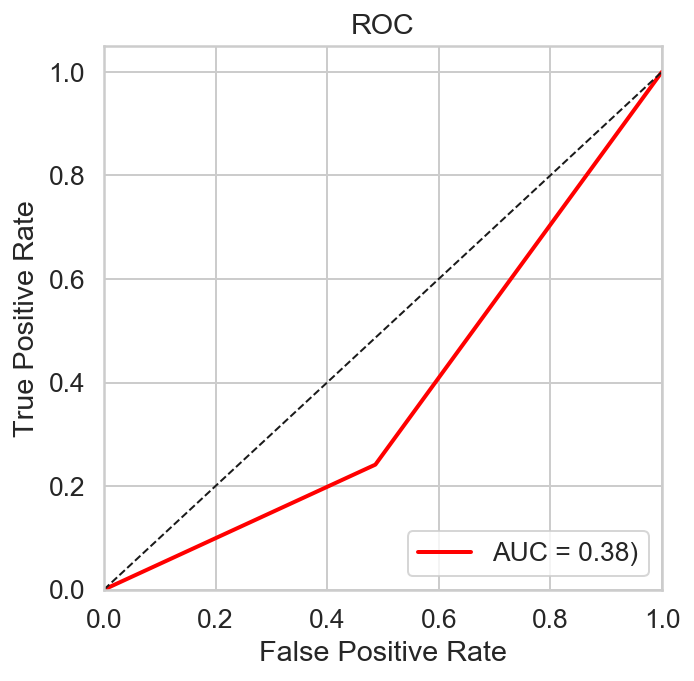

In [1287]:
from sklearn.metrics import *
import pandas as pd
import matplotlib.pyplot as plt

y_test = np.array(preds2['y_test'], dtype=int)
y_score = np.array(preds2['y_score'], dtype=int)


plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc1 = auc(fpr,tpr)

plt.plot(fpr, tpr,label='AUC = %0.2f)' % auc1, 
         #label="AUC Y2:{0}".format(auc1),
         color='red', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Using PCA to reduce multivariate to a uninvariate by slecting the first principle component. 


original shape:    (123, 3)
transformed shape: (123, 1)


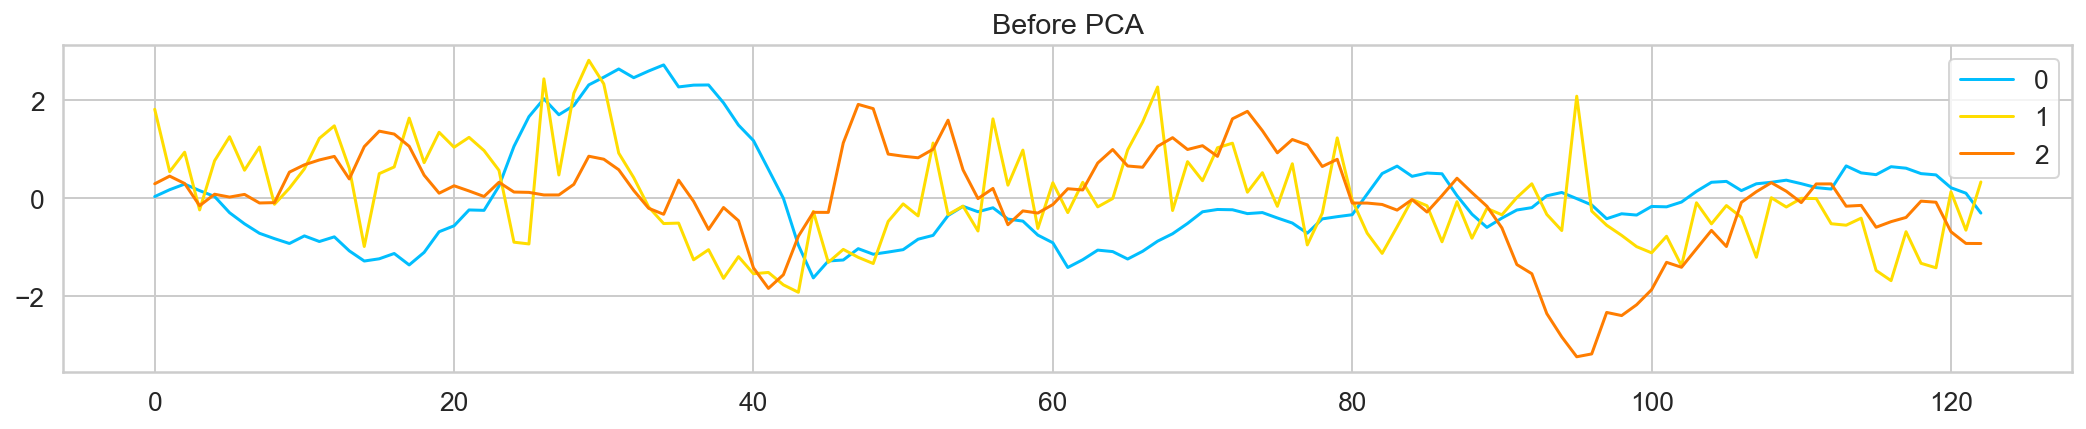

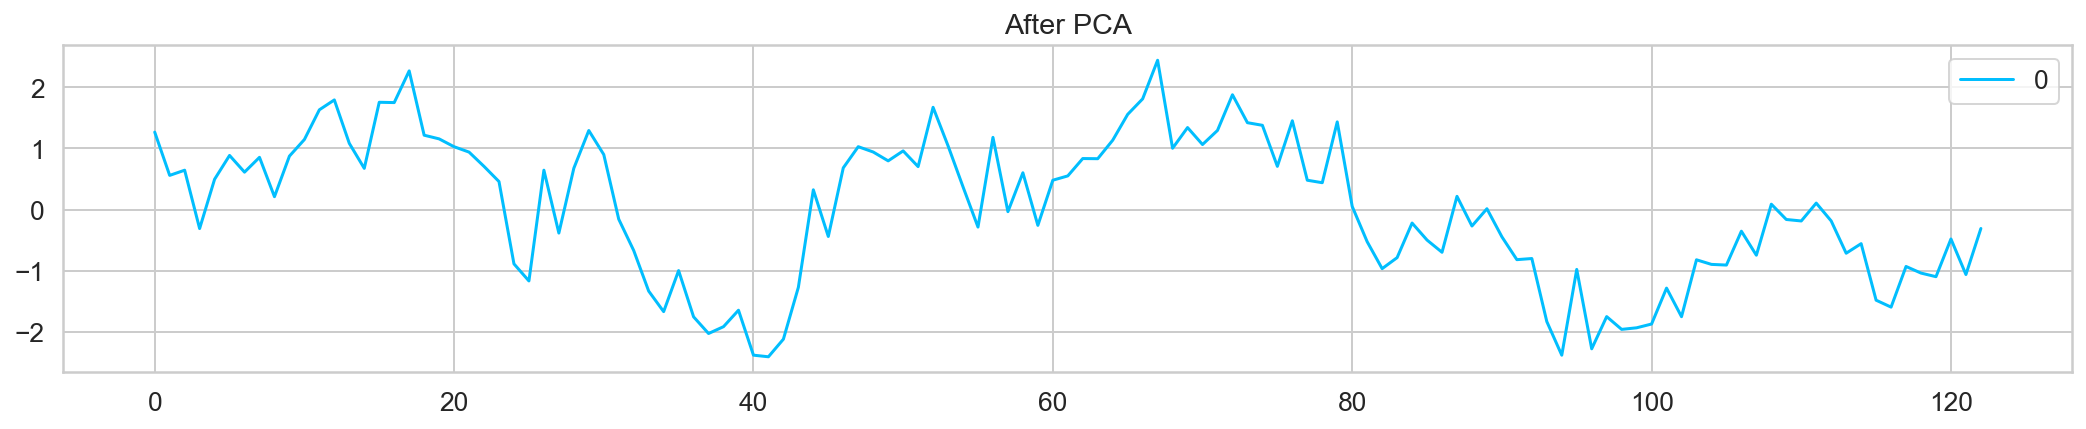

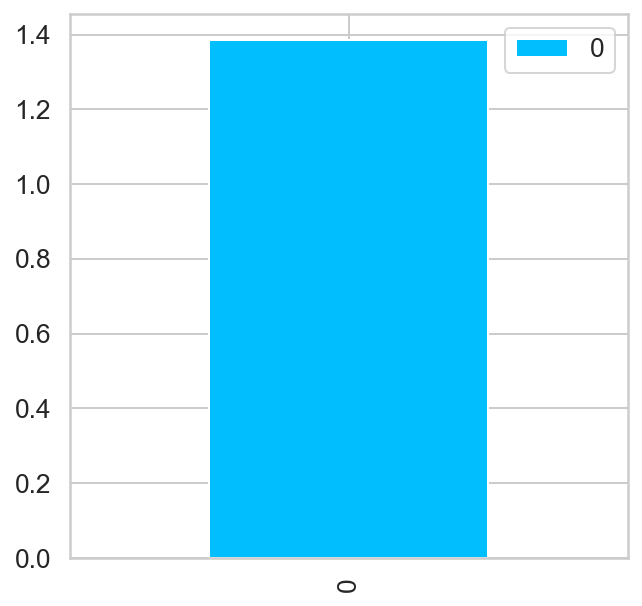

In [1288]:
from sklearn.decomposition import PCA
#import plotly.express as px
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler



df2_fill = df2.ffill()
df2_array = np.array(df2_fill)

pca = decomposition.PCA(n_components=1)
x_std = StandardScaler().fit_transform(df2_array)
df2_pca = pca.fit_transform(x_std)
var = pca.explained_variance_
df2_var = pd.DataFrame(var)
df2_pca = pd.DataFrame(df2_pca)

print("original shape:   ", df2_array.shape)
print("transformed shape:", df2_pca.shape)

# compare the plot with above multi-sennsor output
# the trend looks the same. So using PCA doesn't really help here. 


df2_std = StandardScaler().fit_transform(df2)
df2_std = pd.DataFrame(df2_std)
df2_std.plot(figsize=(18,3), title="Before PCA")


df2_pca.plot(figsize=(18,3), title="After PCA")
df2_var.plot.bar(figsize=(5,5))
